In [1]:
import numpy as np
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [14]:
example = '../data/COMMON_images_masks/common_40_image.nii.gz'
# read image with simpleITK
pelvic_img = sitk.ReadImage(example)
pelvic_img = sitk.Cast(pelvic_img, sitk.sitkFloat32)
pelvic_img_data = sitk.GetArrayFromImage(pelvic_img)

In [11]:
example = '../data/COMMON_images_masks/common_40_mask.nii.gz'
# read image with simpleITK
pelvic_img_mask = sitk.ReadImage(example)
pelvic_img_mask = sitk.Cast(pelvic_img_mask, sitk.sitkFloat32)
pelvic_img_mask_data = sitk.GetArrayFromImage(pelvic_img_mask)

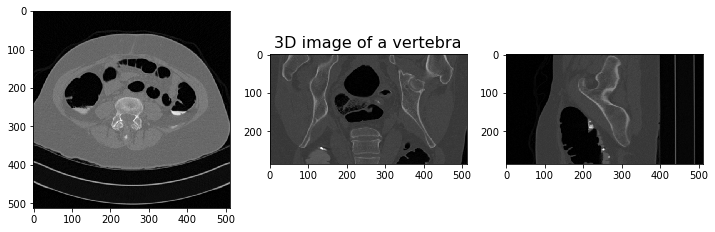

In [18]:
# visualize the images
imageSize=pelvic_img.GetSize()
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(pelvic_img_data[int(imageSize[0]/2),:,:], cmap='gray')
# plt.imshow(pelvic_img_mask_data[int(imageSize[0]/2),:,:])
plt.subplot(132)
plt.title("3D image of a vertebra", size=16)
plt.imshow(pelvic_img_data[:,int(imageSize[1]/2),:], cmap='gray')
# plt.imshow(pelvic_img_mask_data[:,int(imageSize[1]/2),:])
plt.subplot(133)
plt.imshow(pelvic_img_data[:,:,int(imageSize[2]/2)], cmap='gray')
# plt.imshow(pelvic_img_mask_data[:,:,int(imageSize[2]/2)])
plt.show()

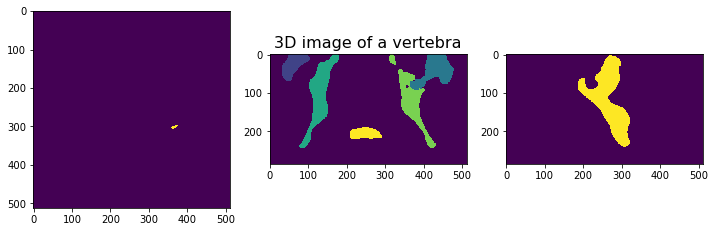

In [19]:
# visualize the images
imageSize=pelvic_img.GetSize()
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(pelvic_img_mask_data[int(imageSize[0]/2),:,:])
plt.subplot(132)
plt.title("3D image of a vertebra", size=16)
plt.imshow(pelvic_img_mask_data[:,int(imageSize[1]/2),:])
plt.subplot(133)
plt.imshow(pelvic_img_mask_data[:,:,int(imageSize[2]/2)])
plt.show()